In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 거리 계산
import math
from geopy.distance import geodesic
import geopy.distance

# 데이터 전처리
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

# 데이터 분할
from sklearn.model_selection import train_test_split

# 학습 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# 성능평가
from sklearn.model_selection import cross_val_score

## 데이터 읽기

In [2]:
df_train = pd.read_csv('./datasets/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

## 아주 기본적인 전처리
- 오브젝트 없애기

In [4]:
# 시내/시외 맵핑
mapping_dict = {'시내': 0, '시외': 1}

df_train['in_out'] = df_train['in_out'].map(mapping_dict)

In [5]:
df_station = df_train[['station_code', 'station_name']]

df_train.drop('station_name', axis=1, inplace=True)

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  int64         
 4   station_code   415423 non-null  int64         
 5   latitude       415423 non-null  float64       
 6   longitude      415423 non-null  float64       
 7   6~7_ride       415423 non-null  float64       
 8   7~8_ride       415423 non-null  float64       
 9   8~9_ride       415423 non-null  float64       
 10  9~10_ride      415423 non-null  float64       
 11  10~11_ride     415423 non-null  float64       
 12  11~12_ride     415423 non-null  float64       
 13  6~7_takeoff    415423 non-null  float64       
 14  7~8_takeoff    415423 non-null  float64       
 15  

In [8]:
df_train.corrwith(df_train['18~20_ride']).sort_values(ascending=False)

18~20_ride       1.000000
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
day              0.004882
id              -0.000544
longitude       -0.021368
bus_route_id    -0.143702
year                  NaN
month                 NaN
dtype: float64

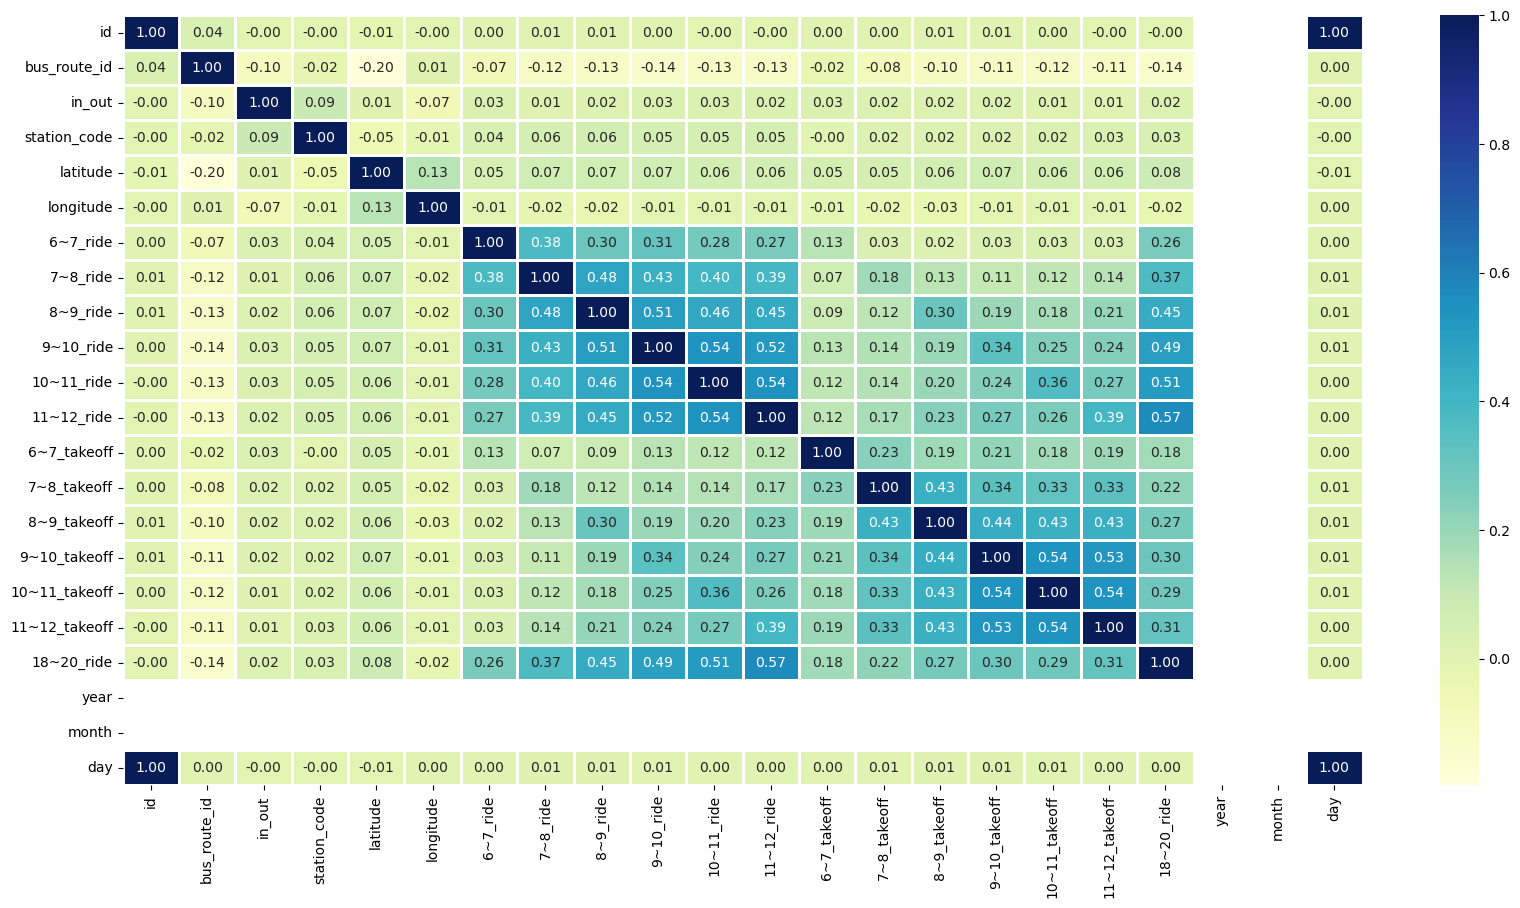

In [9]:
plt.figure(figsize=(20, 10))

sns.heatmap(data=df_train.corr(), annot=True, fmt='.2f', cmap='YlGnBu', linewidth=1.0)
plt.show()

## 기본버전 모델 분석

In [10]:
#돌리기 전 최종, 데이트 날리기
df_train.drop('date', axis=1, inplace=True)

In [11]:
X = df_train.drop('18~20_ride', axis=1)
y = df_train['18~20_ride']

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# 선형회귀
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Train a linear regression model on the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the validation data
lin_scores = cross_val_score(lr_model, X_train, y_train, 
                             scoring="neg_mean_squared_error", 
                             cv=10, n_jobs=-1)
lin_rmse = np.sqrt(-lin_scores.mean())
lin_rmse

3.5618108167385607

In [23]:
# 디시전 트리
# DecisionTree 교차검증
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_train, y_train, 
                              scoring="neg_mean_squared_error", 
                              cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores.mean())
tree_rmse

4.350704495310524

In [22]:
# 랜덤포레스트
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_reg, X_train, y_train, 
                            scoring="neg_mean_squared_error", 
                            cv=3, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores.mean())
rf_rmse

3.0977984431616346

In [13]:
# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
gbrt_reg = GradientBoostingRegressor(random_state=42)
gbrt_scores = cross_val_score(gbrt_reg, X_train, y_train, 
                              scoring="neg_mean_squared_error", 
                              cv=10, n_jobs=-1)
gbrt_rmse = np.sqrt(-gbrt_scores.mean())
gbrt_rmse

3.288528325115023

In [ ]:
#svm 정규화 기다리고 있겠읍니다. 동심님


## 라이드섬 테잌옾섬

In [11]:
# 승차인원 및 하차인원 총계 column 추가
df_train['ride_sum'] = df_train['6~7_ride'] + df_train['7~8_ride'] + df_train['8~9_ride'] + df_train['9~10_ride'] + df_train['10~11_ride'] + df_train['11~12_ride']
df_train['takeoff_sum'] = df_train['6~7_takeoff'] + df_train['7~8_takeoff'] + df_train['8~9_takeoff'] + df_train['9~10_takeoff'] + df_train['10~11_takeoff'] + df_train['11~12_takeoff']

In [10]:
# 승차 시간대 column명
ride_attributes = ['11~12_ride', '10~11_ride', '9~10_ride', '8~9_ride', '7~8_ride', '6~7_ride']
# 하차 시간대 column명
takeoff_attributes = ['11~12_takeoff', '10~11_takeoff', '9~10_takeoff', '8~9_takeoff', '7~8_takeoff', '6~7_takeoff']
df_train['ride_sum'] = 0
df_train['takeoff_sum'] = 0
for i in range(len(ride_attributes)):
    df_train['ride_sum'] += df_train[ride_attributes[i]]
    df_train['takeoff_sum'] += df_train[takeoff_attributes[i]]

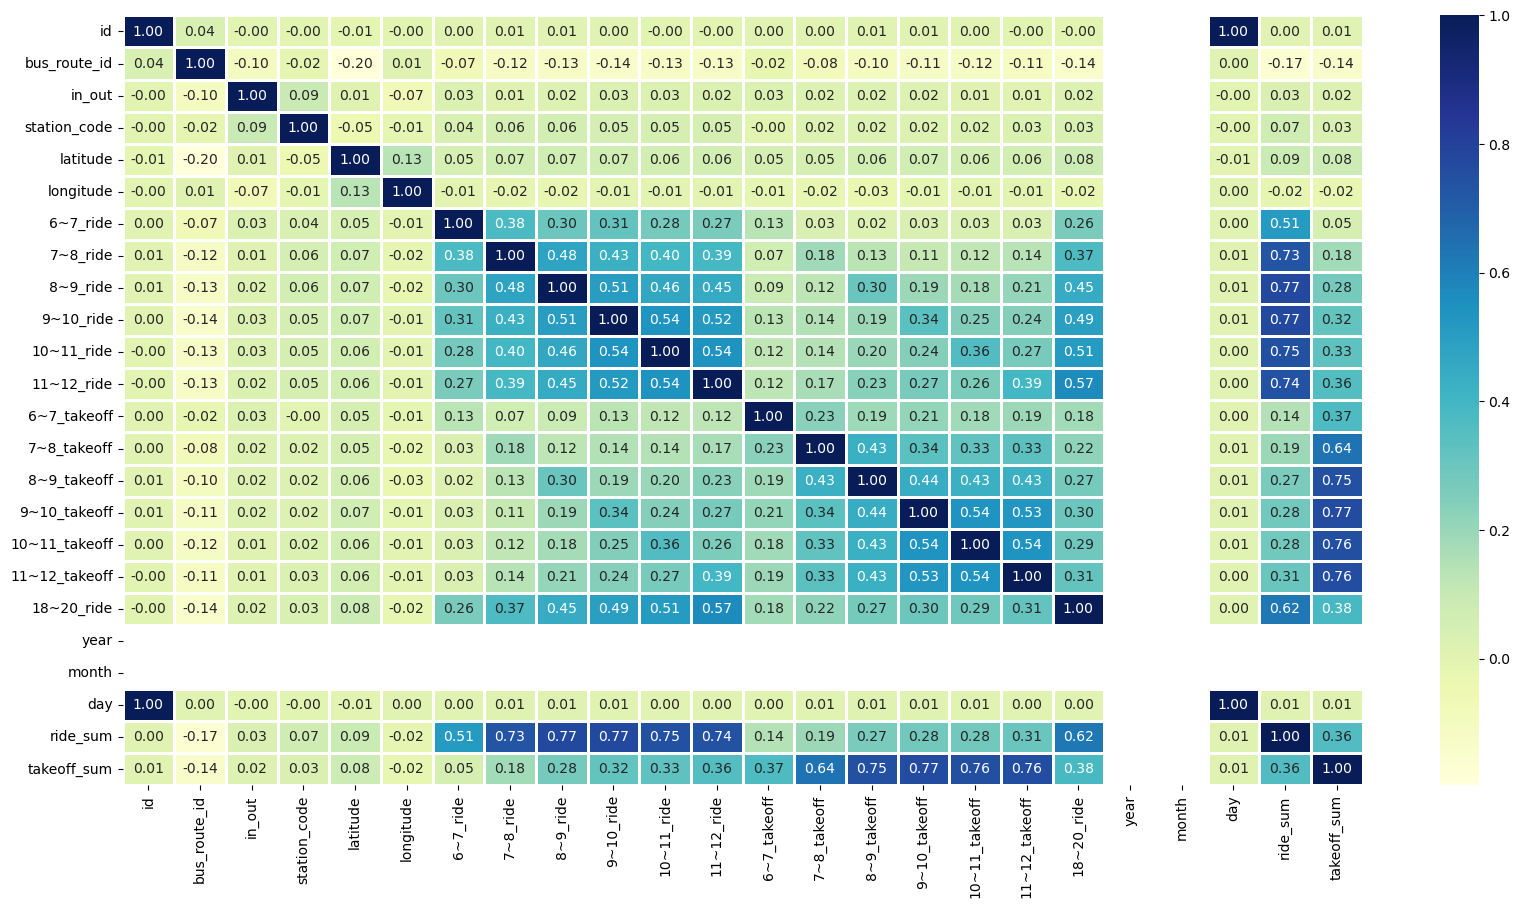

In [11]:
plt.figure(figsize=(20, 10))

sns.heatmap(data=df_train.corr(), annot=True, fmt='.2f', cmap='YlGnBu', linewidth=1.0)
plt.show()

In [12]:
X = df_train.drop('18~20_ride', axis=1)
y = df_train['18~20_ride']

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [13]:
# 선형회귀
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=42)

# Train a linear regression model on the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the validation data
lin_scores = cross_val_score(lr_model, X_train, y_train, 
                             scoring="neg_mean_squared_error", 
                             cv=10, n_jobs=-1)
lin_rmse = np.sqrt(-lin_scores.mean())
lin_rmse

3.5618108167379083

In [14]:
# 디시전 트리
# DecisionTree 교차검증
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores.mean())
tree_rmse

4.148298917952389

In [15]:
# 랜덤포레스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores.mean())
rf_rmse

2.9512892353825944

In [13]:
# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
gbrt_reg = GradientBoostingRegressor(random_state=42)
gbrt_scores = cross_val_score(gbrt_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
gbrt_rmse = np.sqrt(-gbrt_scores.mean())
gbrt_rmse

3.288528325115023